In [89]:
%matplotlib notebook
from IPython.display import Image

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import matplotlib.animation as animation

In [90]:
import os
import h5py
import torch
import numpy as np
from sklearn import decomposition

from orthonet import jacob

### Load Data & Model

In [94]:
BASE_PATH = '/u/xl/tjlane/cryoem/dynanet/particle_simulations/ortho/toys/circ_sigma2/'
MODEL_PATH = BASE_PATH + 'ortho_vae-3.00e-01_ob4.00e+04_db1.00e+00'

DATA_PATH  = '/u/xl/tjlane/opt/orthonet/toymodels'

In [92]:
# load some data
f = h5py.File(DATA_PATH + '/bot_quarter_circle_sigma2.00.h5','r')
origin = np.array(f['data'])
r      = np.array(f['r'])
theta  = np.array(f['theta'])
f.close()

In [93]:
def load_model(model_path, original_data):

    model = torch.load(model_path + '/model.pt')

    ot = torch.tensor(original_data.astype(np.float32))
    latent = model.encode(ot).detach().numpy()
    recon  = model(ot)

    # deals with VAE case where I also saved logvar, use only mu here
    if type(recon) == tuple:
        recon = recon[0].detach().numpy()
    else:
        recon = recon.detach().numpy()

    return model, latent, recon

model, latent, recon = load_model(MODEL_PATH, origin)
#model.eval()

FileNotFoundError: [Errno 2] No such file or directory: '/u/xl/tjlane/cryoem/dynanet/particle_simulations/ortho/toys/semicirc_noise/ortho_vae-3.00e-01_ob4.00e+04_db1.00e+00/model.pt'

### Take a look at the training curves and direct latent space

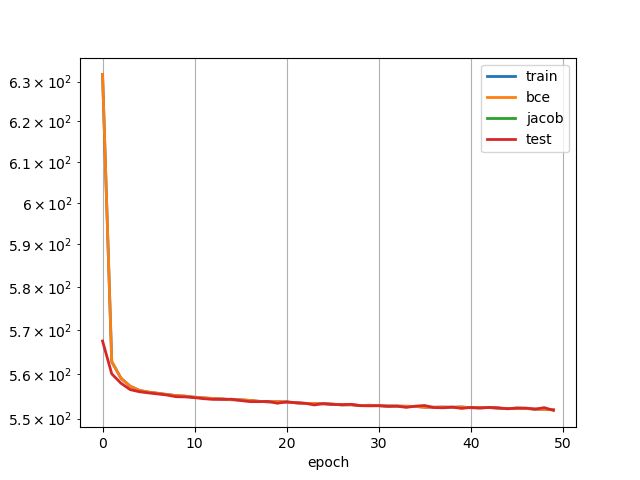

In [81]:
Image(filename=MODEL_PATH + '/loss_curves.png')

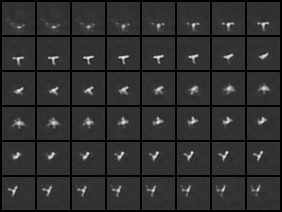

In [82]:
Image(filename=MODEL_PATH + '/z0.png')

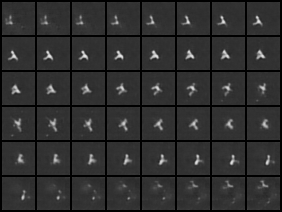

In [83]:
Image(filename=MODEL_PATH + '/z1.png')

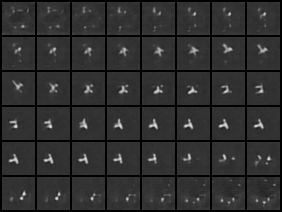

In [84]:
Image(filename=MODEL_PATH + '/z2.png')

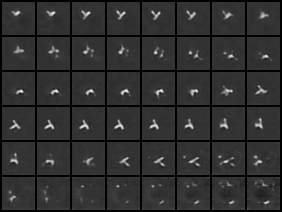

In [85]:
Image(filename=MODEL_PATH + '/z3.png')

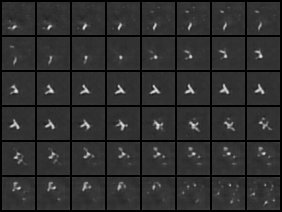

In [86]:
Image(filename=MODEL_PATH + '/z4.png')

### PCA Analysis of Latent Space

<IPython.core.display.Javascript object>


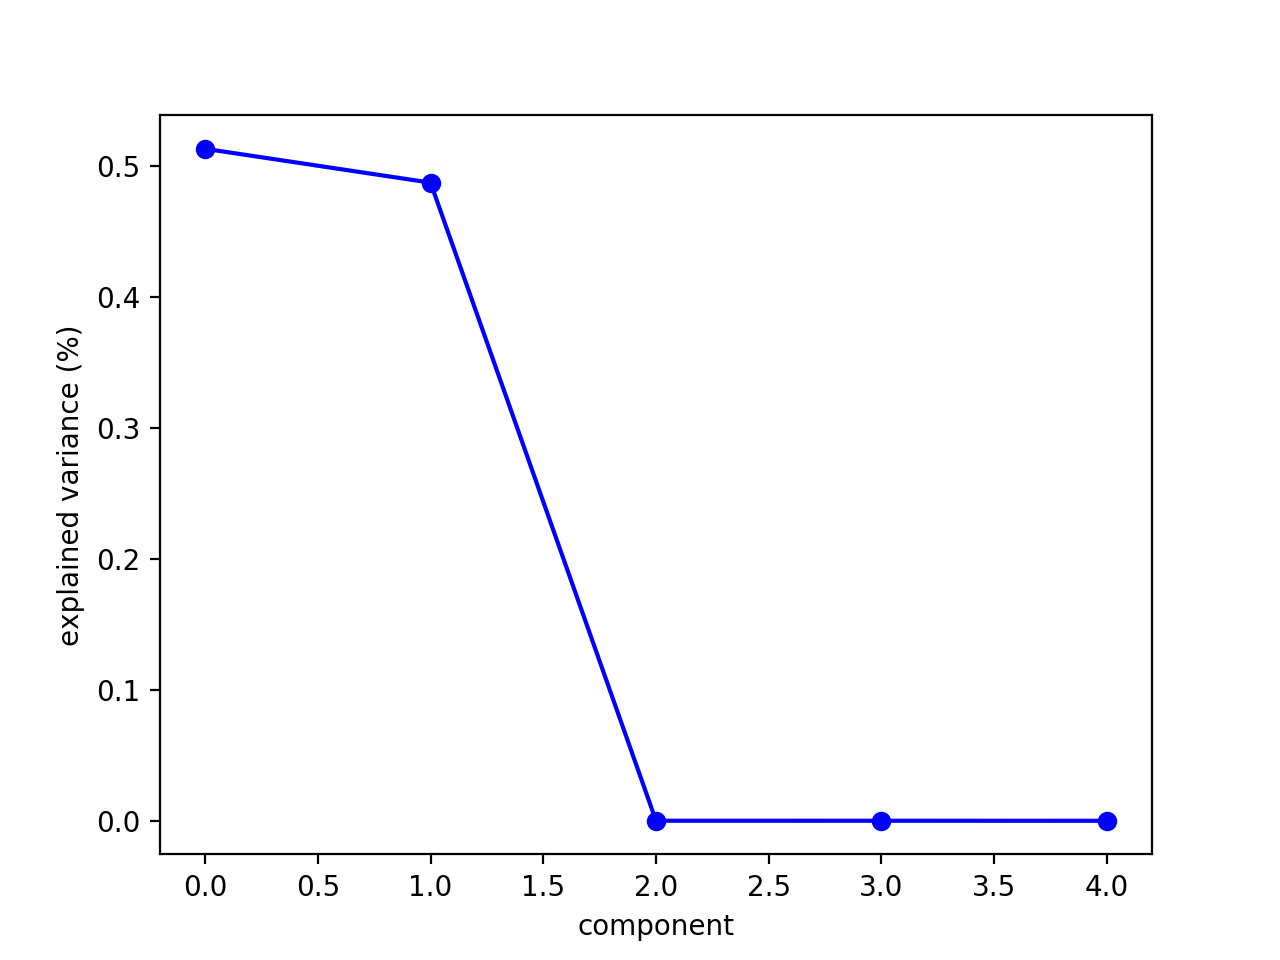

In [87]:
n_components = latent.shape[1]

pca = decomposition.PCA(n_components=n_components)
pca.fit(latent)

plt.figure()
plt.plot(pca.explained_variance_ratio_, 'bo')
plt.plot(pca.explained_variance_ratio_, 'b-')
plt.xlabel('component')
plt.ylabel('explained variance (%)')
plt.savefig(MODEL_PATH+'/pca_spectrum.pdf')
plt.show()

In [57]:
# # trace out the PC space

# model.eval()

# lim = 2 # 2
# res = 0.01 # 0.05
# fps = 60

# basis = 'pcs'
# #basis = 'latent'

# component = 1

# if basis == 'pcs':
#     z = pca.components_[component]
# elif basis == 'latent':
#     z = np.eye(n_components)[component]

# s = np.arange(-lim,lim,res)
# z = np.outer(s, z).astype(np.float32)
# x = torch.tensor(z)
# rx = model.decode(x).detach().numpy()


# fig = plt.figure()
# ax = plt.subplot(111)
# ax.axis('off')
# ims = []
# for ri in rx:
#     ims.append( [plt.imshow(ri, animated=True)] )
# ani = animation.ArtistAnimation(fig, ims, interval=fps, blit=False,
#                                 repeat_delay=0)
# ani.save('/u/xl/tjlane/%s_%d_movie.mp4' % (basis, component), 
#         fps=fps)
# plt.show()

(25000, 5)


<IPython.core.display.Javascript object>


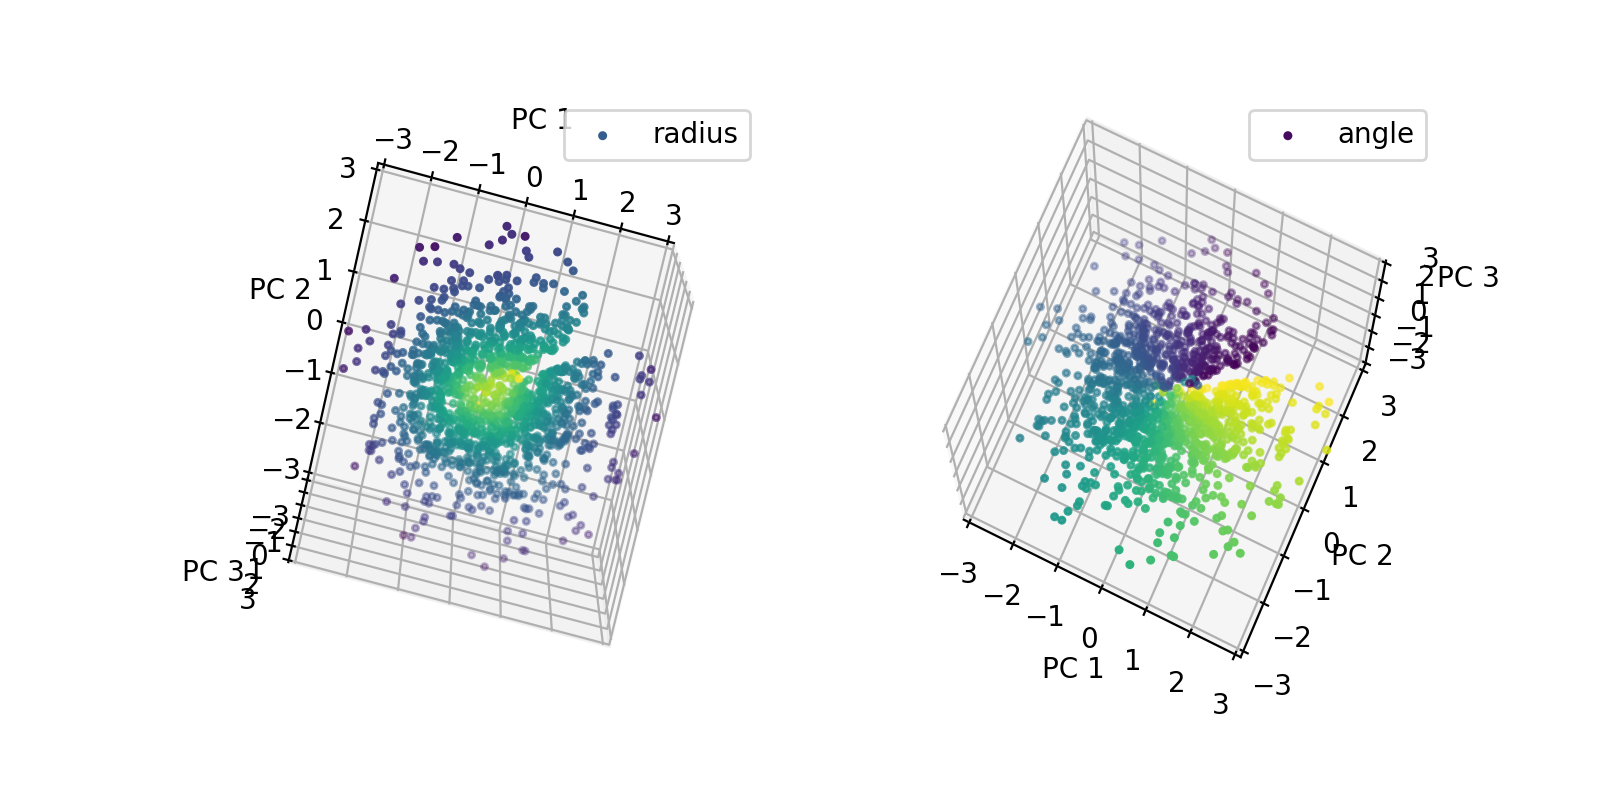

In [88]:
max_pts = 1280
l = 3 # plot limits

latent_in_pc = pca.transform(latent)
print(latent_in_pc.shape)

fig = plt.figure(figsize=(8,4))

ax = fig.add_subplot(121, projection='3d')

ax.scatter(latent_in_pc[:max_pts,0],
           latent_in_pc[:max_pts,1],
           latent_in_pc[:max_pts,2],
           c=r[:max_pts], marker='.')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.legend(['radius'])

ax.set_xlim([-l,l])
ax.set_ylim([-l,l])
ax.set_zlim([-l,l])


ax = fig.add_subplot(122, projection='3d')

ax.scatter(latent_in_pc[:max_pts,0],
           latent_in_pc[:max_pts,1],
           latent_in_pc[:max_pts,2],
           c=theta[:max_pts], marker='.')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.legend(['angle'])

ax.set_xlim([-l,l])
ax.set_ylim([-l,l])
ax.set_zlim([-l,l])

plt.savefig(MODEL_PATH+'/latent.pdf')
plt.show()

### Direct look at the Jacobian of the resulting network

In [58]:
n_samples = 128
n_outputs = torch.tensor(np.product(origin.shape[1:]))

J = np.zeros([1089, 5])
for i in range(n_samples):
    Jx = jacob.jacobian(model.decode, torch.tensor(latent[i]), n_outputs)
    J += Jx.detach().numpy()

KeyboardInterrupt: 

In [ ]:
J_pca = decomposition.PCA(n_components=J.shape[1])
J_pca.fit(J)

plt.figure()
plt.plot(J_pca.explained_variance_ratio_, 'bo')
plt.plot(J_pca.explained_variance_ratio_, 'b-')
plt.xlabel('component')
plt.ylabel('explained variance (%)')
plt.savefig(MODEL_PATH+'/pca_spectrum.pdf')
plt.show()

In [ ]:
JG = np.dot(J.T, J)

plt.figure()
plt.title('Jacobian-Grammian')
plt.imshow(JG)

for (j,i),label in np.ndenumerate(JG):
    plt.text(i, j, np.round(label,3), ha='center', va='center', color='w')
    
plt.show()

### Investigate the effect of parameters on the dimensionality of the latent space

In [95]:
dbeta = 1.0
obetas = [1e4, 2e4, 4e4, 6e4, 8e4, 1e5]
vbetas = [0.1, 0.3, 1.0]

variance_cutoff = 1e-2

n_dimensions = np.zeros((len(vbetas), len(obetas)))

for i,vbeta in enumerate(vbetas):
    for j,obeta in enumerate(obetas):

        model_path = BASE_PATH + 'ortho_vae-%.2e_ob%.2e_db%.2e' % (vbeta, obeta, dbeta)
        
        if os.path.exists(model_path + '/model.pt'):
        
            _, latent, _ = load_model(model_path, origin)
            n_components = latent.shape[1]

            pca = decomposition.PCA(n_components=n_components)
            pca.fit(latent)

            nd = np.sum(pca.explained_variance_ratio_ > variance_cutoff)
            print(obeta, vbeta, pca.explained_variance_ratio_)
            n_dimensions[i,j] = nd

/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


10000.0 0.1 [5.9386981e-01 4.0606725e-01 4.6980356e-05 1.2750691e-05 3.2818871e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


20000.0 0.1 [6.8416595e-01 2.7974054e-01 3.6083348e-02 8.1805365e-06 2.1325732e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


40000.0 0.1 [5.6149578e-01 2.8544328e-01 1.5128888e-01 1.6270264e-03 1.4510934e-04]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


60000.0 0.1 [7.9305053e-01 2.0582920e-01 9.8972279e-04 9.8634591e-05 3.1918174e-05]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


80000.0 0.1 [7.3239511e-01 2.6750997e-01 7.7927209e-05 1.1776713e-05 5.2342971e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


100000.0 0.1 [5.2787709e-01 2.6034299e-01 2.1150903e-01 2.5443389e-04 1.6592445e-05]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


10000.0 0.3 [6.1779636e-01 3.8215506e-01 4.2906890e-05 4.4492676e-06 1.1151539e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


20000.0 0.3 [6.1523414e-01 3.8467929e-01 7.7990080e-05 7.1999498e-06 1.4403357e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


40000.0 0.3 [9.9937510e-01 5.0001527e-04 9.4033559e-05 2.7839664e-05 3.1219904e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


60000.0 0.3 [6.54334247e-01 3.45527709e-01 1.00611476e-04 3.20672261e-05
 5.32139484e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


80000.0 0.3 [9.9942470e-01 3.2264105e-04 1.5687625e-04 7.9654907e-05 1.6137335e-05]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


100000.0 0.3 [9.9853325e-01 8.7167835e-04 3.6570989e-04 1.8947429e-04 3.9997838e-05]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


10000.0 1.0 [9.9938035e-01 4.7790507e-04 1.1948551e-04 2.0237912e-05 1.9692181e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


20000.0 1.0 [6.3766998e-01 3.6230329e-01 2.4799370e-05 1.5003718e-06 4.3188001e-07]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


40000.0 1.0 [6.7671072e-01 3.2327488e-01 1.2596100e-05 1.2835101e-06 6.2151423e-07]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


60000.0 1.0 [9.9957269e-01 2.2684509e-04 1.0839758e-04 7.5607262e-05 1.6435024e-05]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


80000.0 1.0 [9.9968886e-01 2.6543922e-04 2.5718811e-05 1.2981141e-05 7.0323717e-06]


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'orthonet.models.VAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


100000.0 1.0 [9.9988908e-01 7.8479083e-05 2.1197271e-05 8.3413570e-06 2.9680587e-06]


<IPython.core.display.Javascript object>


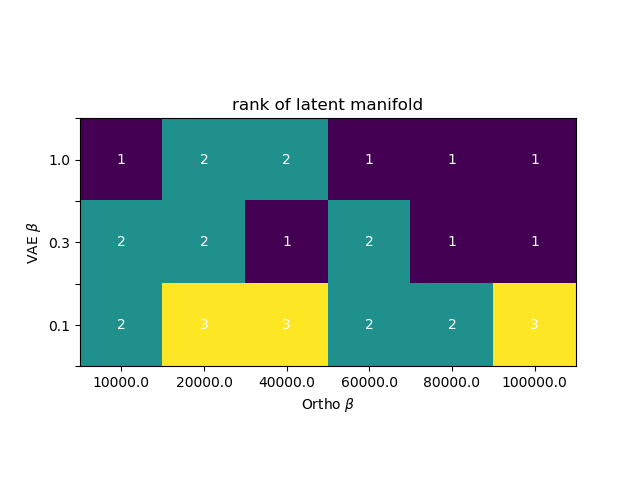

/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


In [96]:
plt.figure()

plt.title('rank of latent manifold')

ax = plt.subplot(111)
ax.imshow(n_dimensions, aspect=1, origin='bottomleft')

#ax.set_yticklabels(['x'] + list(vbetas))
ax.set_yticklabels(['', '0.1', '', '0.3', '', '1.0'])
ax.set_xticklabels(['x'] + list(obetas)[:])
plt.ylabel(r'VAE $\beta$')
plt.xlabel(r'Ortho $\beta$')

for (j,i),label in np.ndenumerate(n_dimensions):
    plt.text(i, j, int(label), ha='center', va='center', color='w')

plt.show()